# Setups, Installations and Imports

In [2]:
!nvidia-smi

Tue Feb 21 12:19:36 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 528.24       Driver Version: 528.24       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   42C    P8    20W / 200W |   2247MiB /  8192MiB |     15%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
%%capture
!pip install wandb

In [1]:
SEED = 666

import tensorflow as tf
tf.random.set_seed(SEED)

from tensorflow import keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications.resnet50 import ResNet50

In [5]:
import os
os.environ["TF_DETERMINISTIC_OPS"] = "1"

import numpy as np
np.random.seed(SEED)

import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

from mpl_toolkits.axes_grid1 import ImageGrid
from PIL import Image

import tensorflow_datasets as tfds

c:\Users\Usuario\Documents\proyectos\smart_parking\carnet\.venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
import wandb
from wandb.keras import WandbCallback

wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jhon-zelada-r. Use `wandb login --relogin` to force relogin


True

# GPU Availability

In [7]:
print('GPU name: ', tf.config.experimental.list_physical_devices('GPU'))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

GPU name:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1


#### Setup GPU Growth

In [8]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


# Download and Prepare Dataset

In [9]:
train_ds, validation_ds = tfds.load(
    'horses_or_humans',
    split=['train[:85%]', 'train[85%:]'],
    as_supervised=True
)

# Visualize

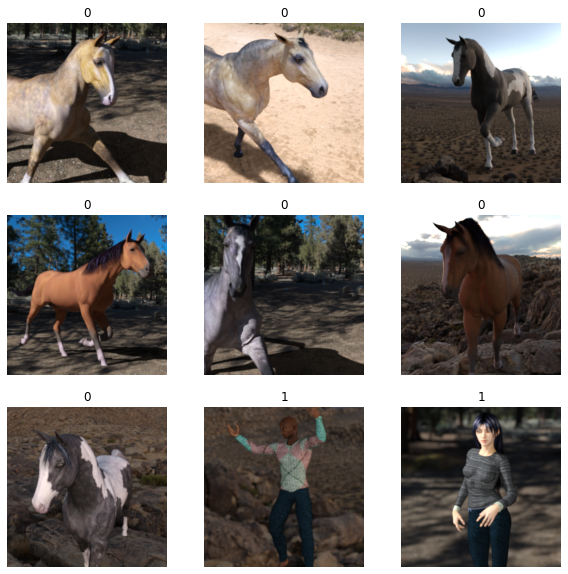

In [10]:
# Reference: https://keras.io/guides/transfer_learning/
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis('off')

# Dataloader

In [11]:
AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32
IMG_SHAPE = 224
CHANNELS = 3
NUM_CLASSES = 2

In [12]:
def preprocess_image(image, label):
    image = tf.image.resize(image, (IMG_SHAPE, IMG_SHAPE))
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = image/255.
    return (image, label)

In [13]:
train_ds = (
    train_ds
    .map(preprocess_image, num_parallel_calls=AUTO)
    .shuffle(1024)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

validation_ds = (
    validation_ds
    .map(preprocess_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

# Model

In [14]:
def Model():
  inputs = keras.layers.Input(shape=(IMG_SHAPE, IMG_SHAPE, 3))

  resnet = ResNet50(include_top=False, weights=None, input_tensor=inputs)
  x = resnet.layers[-1].output

  x = keras.layers.GlobalAveragePooling2D()(x)
  outputs = keras.layers.Dense(1, activation='sigmoid')(x)

  return keras.models.Model(inputs, outputs)

# Initialize Model

In [15]:
keras.backend.clear_session()
model = Model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

# Compile

In [16]:
model.compile('adam', 'binary_crossentropy', metrics=['acc'])

# Wandb Init

In [17]:
wandb.init(entity='jhon-zelada-r', project='Prueba')

# Train

In [18]:
EPOCHS = 3

_ = model.fit(train_ds,
          epochs=EPOCHS,
          validation_data=validation_ds,
          callbacks=[WandbCallback()])

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/3
 6/28 [=====>........................] - ETA: 4s - loss: 1.6276 - acc: 0.6406WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0946s vs `on_train_batch_end` time: 0.1110s). Check your callbacks.


28/28 [==============================] - 32s 293ms/step - loss: 0.8459 - acc: 0.7056 - val_loss: 1.7095 - val_acc: 0.4416


c:\Users\Usuario\Documents\proyectos\smart_parking\carnet\.venv\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: c:\Users\Usuario\Documents\proyectos\smart_parking\carnet\wandb\run-20230221_121944-fi5d566t\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\Usuario\Documents\proyectos\smart_parking\carnet\wandb\run-20230221_121944-fi5d566t\files\model-best\assets
c:\Users\Usuario\Documents\proyectos\smart_parking\carnet\.venv\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
wandb: Adding directory to artifact (c:\Users\Usuario\Documents\proyectos\smart_parking\carnet\wandb\run-20230221_121944-fi5d566t\files\model-best)... Done. 0.8s


Epoch 2/3
28/28 [==============================] - 6s 213ms/step - loss: 0.2838 - acc: 0.8832 - val_loss: 1.0360 - val_acc: 0.4416
INFO:tensorflow:Assets written to: c:\Users\Usuario\Documents\proyectos\smart_parking\carnet\wandb\run-20230221_121944-fi5d566t\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\Usuario\Documents\proyectos\smart_parking\carnet\wandb\run-20230221_121944-fi5d566t\files\model-best\assets
c:\Users\Usuario\Documents\proyectos\smart_parking\carnet\.venv\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
wandb: Adding directory to artifact (c:\Users\Usuario\Documents\proyectos\smart_parking\carnet\wandb\run-20230221_121944-fi5d566t\files\model-best)... Done. 0.7s


Epoch 3/3
28/28 [==============================] - 6s 211ms/step - loss: 0.2072 - acc: 0.9141 - val_loss: 4.1540 - val_acc: 0.4416


# Evaluate

In [19]:
loss, accuracy = model.evaluate(validation_ds, callbacks=[WandbCallback()])
print('Test Error Rate: ', round((1-accuracy)*100, 2))
wandb.log({'Test Error Rate': round((1-accuracy)*100, 2)})

5/5 [==============================] - 0s 54ms/step - loss: 4.1540 - acc: 0.4416
Test Error Rate:  55.84
